# Machine Learning – TDT4173 Group Project 
### [47] Extreme Machine Learning
##### Alessandro Donadi - 133756
##### Gian Marco Miccio - 133705
##### Giulia Papalini - 133534

## **Introduction**

The models that have been chosen for the task after several trials are Random Forest Regressor and Extra Trees. They are very similar models, with similar performaces, Random Forest has higher variance and lower bias and it gets the best score in the public score, while Extra Tress has lower variance and so it should prevent overfitting and be more robust. The chosen features are past latitude, past longitude and the difference in time between the past observation and the present instance. latitude and longitude are lag variables, taken 5 times in the past, up to 124 observations in the past.

The steps followed to end up with this configuration of models, features and hyperparameters are presented below. In this report you will find:
- **Exploratory Data Analysis**: the initial analysis done on the raw data to understand individual feature, feature's relationships, missing and anomalous values
- **Feature Engineering**: all changes done to existent features, introduction of new features based on the existent ones, combinations of features and shifts in the past, use of Tfresh and Bayesian Optimization to investigate optimal lag selection
- **Models Used**: list of the models used in the project, comprehensive of the ones not used for the submissions too, accompanied by a description of the function built to actually make the predictions one at a time
- **Hyperparameter optimization**: function used to optimize hyperparameters for the algorithms used during the project
- **Feature Importance**: study of the meaning of the single features in the models used, in the form of PDP and feature importance by weight.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import category_encoders as ce
from feature_engine.encoding import MeanEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder
import math
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely.ops import nearest_points
import tempfile
from dask.distributed import Client
from joblib import Parallel, delayed
import os
from shapely.strtree import STRtree
import time
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

import joblib

In [3]:
# import data

X_train = pd.read_csv("ais_train.csv", delimiter='|')
X_test = pd.read_csv("ais_test.csv", delimiter=',')
vessels = pd.read_csv("vessels.csv", delimiter='|')
ports = pd.read_csv("ports.csv", delimiter='|')
schedules = pd.read_csv("schedules_to_may_2024.csv", delimiter='|')

## **Exploratory Data Analysis**

The first steps taken towards tackling the project were in the form of data understanding: a first rundown of the data through graphical representations and missing value counting helped with getting a hang of how the data is structured and behaved. A lot of these inferences were made referencing the document containing the definitions and explanations of the dataset.  

#### Domain knowledge
We started to research relevant domain documentation with the 'Dataset definitions and explanation' file to understand the available materials. An analysis was conducted for each feature, using technical resources like AIS technical documentation and papers on latitude and longitude regression of vessels trajectory. This approach allowed us to gain insight into the challenges and the necessary controls to be implemented.

In [5]:
#PRE-PROCESSING
df = X_train.copy()
df.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


After importing the data, the focus shifted to individual variables: **COG** was shown to not have anomalous data (above 360 or below 0), and the default values of 360 were converted to NaNs. A boxplot of the distribution of the data is shown below.

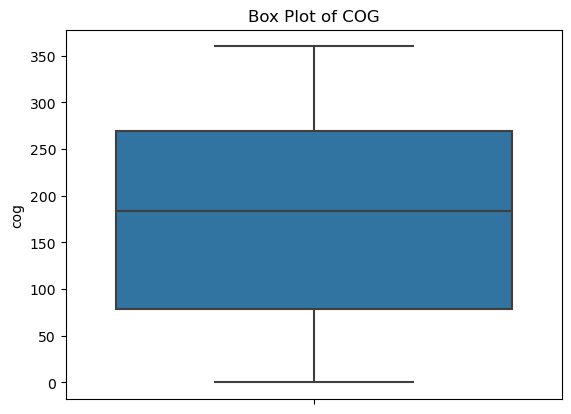

not available (equal to 360):  5858
anomalous (greater then 360):  0
CONTROL (must be zero):  0
CONTROL (must be zero):  0


In [8]:
#COG
sns.boxplot(y=X_train['cog'])
plt.title('Box Plot of COG')
plt.show()

cog_not_available = (X_train['cog'] == 360).sum()
cog_anomalous = (X_train['cog'] > 360).sum()

print("not available (equal to 360): ", cog_not_available)
print("anomalous (greater then 360): ", cog_anomalous)

df.loc[df['cog']>=360, 'cog'] = np.nan

cog_not_available_df = (df['cog'] == 360).sum()
cog_anomalous_df = (df['cog'] > 360).sum()

print("CONTROL (must be zero): ", cog_not_available_df)
print("CONTROL (must be zero): ", cog_anomalous_df)


**SOG** was shown to have no missing values (classified as equal to 1023), and the great majority of the data was actually shown to be below a threshold of 100, strengthening the case that the data was coherent. Some of the data shown in the boxplot could be considered outliers, and for that reason they were removed and classified as NaNs. 

missing values: 0
possible outliers: 417
check (must be 0): 0


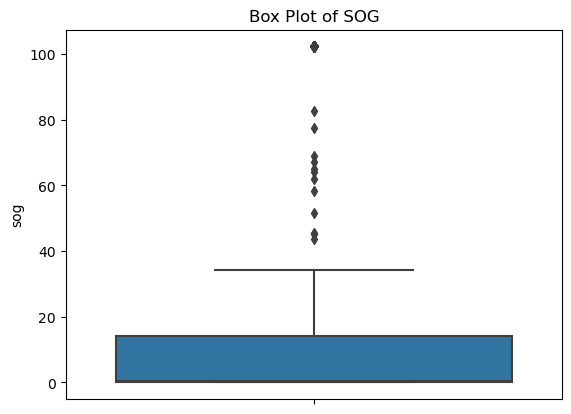

(1522065, 11)

In [10]:
# 2. sog
# many of these have value 0, like half of the observations, while very few (only 405) have value above 100
# none have value 1023 -> no missing values!
print('missing values:', df[df.sog>=1000].sog.count())
print('possible outliers:', df[df.sog>=40].sog.count())
df.loc[df['sog']>=40, 'sog'] = np.nan
print('check (must be 0):', df[df.sog>=40].sog.count())
sns.boxplot(y=X_train['sog'])
plt.title('Box Plot of SOG')
plt.show()
df.shape
#df.head()

The same  was repeated for the features of **heading** and **ROT**. Missing and anomalous values were checked (greater or equal than 360 for heading, -128, +-127 for ROT) and removed from the dataset. Boxplots for the features are shown in their respective figure. 

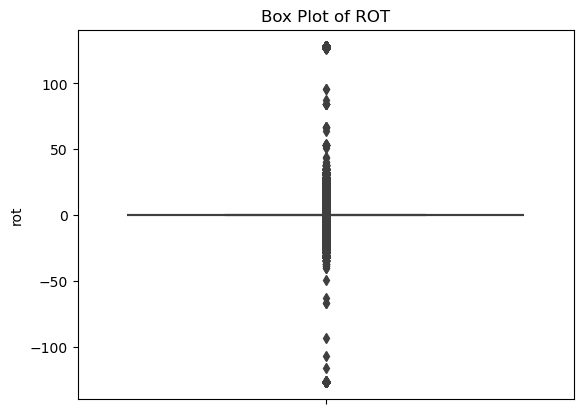

not available (== -128):  0
turning right slowly ( == 127):  11339
turning left slowly (== -127):  11042
CONTROL (must be zero):  0
CONTROL (must be zero):  0


In [12]:
# ROT
sns.boxplot(y=df['rot'])
plt.title('Box Plot of ROT')
plt.show()

rot_right = (X_train['rot'] == 127).sum()
rot_left = (X_train['rot'] == -127).sum()
rot_unknown = (X_train['rot'] == -128).sum()

print("not available (== -128): ", rot_unknown)
print("turning right slowly ( == 127): ", rot_right)
print("turning left slowly (== -127): ", rot_left)

#new feature: 
#  - if rot is present the value is zero
#  - if rot is not present and it's turning right slowly +1
#  - if rot is not present and it's turning left slowly -1


df['slow_turn'] = 0
df.loc[df['rot']==127, 'slow_turn'] = 1
df.loc[df['rot']==-127, 'slow_turn'] = -1

# cleaning rot from beforementioned flags
df.loc[df['rot']==127, 'rot'] = np.nan
df.loc[df['rot']<=-127, 'rot'] = np.nan


rot_right_check = (df['rot'] == 127).sum()
rot_left_check = (df['rot'] == -127).sum()
print("CONTROL (must be zero): ", rot_right_check)
print("CONTROL (must be zero): ", rot_left_check)

missing + anomalous values: 4896
only missing values: 4895
check (must be 0) 0


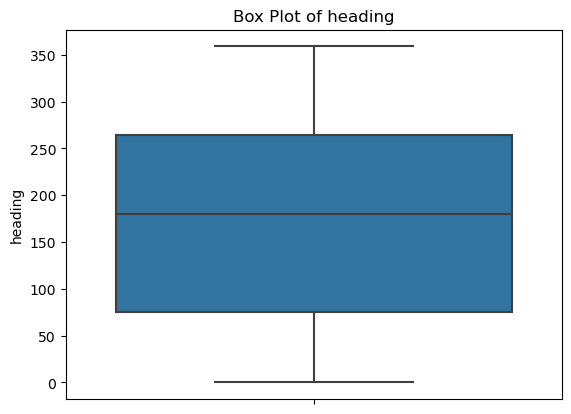

In [13]:
# 4. heading
#checking >= 360 as that's the same as ==511 but covers for the possibility of a random anomalous datum above 359
print('missing + anomalous values:', df[df.heading>=360].heading.count())
print('only missing values:', df[df.heading==511].heading.count())
# df[df.heading=511].heading didn't work, creates a copy of the dataframe, not the dataframe itself
# 4895 missing values
df.loc[df.heading>=360, "heading"]=np.nan
print('check (must be 0)', df[df.heading>=360].heading.count())
sns.boxplot(y=df['heading'])
plt.title('Box Plot of heading')
plt.show()

**Navstat** was also tweaked to remove non relevant classes and a histogram was used to observe the different values it can take

navstat:  5
navstat_not_defined:  670


<Axes: xlabel='navstat', ylabel='count'>

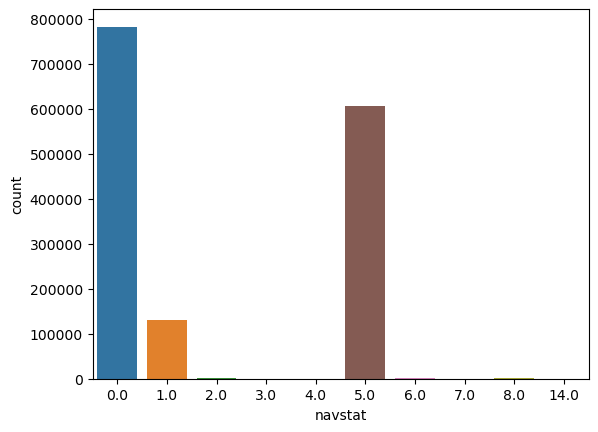

In [15]:
# NAVSTAT

classes_to_be_removed = df['navstat'].isin([9,10,11,12,13]).sum()
print("navstat: ", classes_to_be_removed)
navstat_not_defined = (X_train['navstat'] == 15).sum()
print("navstat_not_defined: ", navstat_not_defined)

df.loc[df['navstat'].isin([9, 10, 11, 12, 13]), 'navstat'] = np.nan
df.loc[df['navstat'] == 15] = np.nan

sns.countplot(x='navstat', data=df)

The **time** feature was converted to an integer, and the same process was applied to **etaRaw** after setting all non-existent dates, such as 00-00, to NaN. Additionally, it was observed that the dates in ‘etaRaw’ lacked the year, which led to the decision not to use this feature subsequently, as assuming the year to be 2024 was not consistently accurate. 

In [17]:
# CONVERT TIME INTO INT
#print(type(df['time'][0]))
#print((pd.to_datetime(df.time[0])))
df["time"]=pd.to_datetime(df.time)
#print(type(df.time[0]))
df['time_int']=df['time'].astype('int64') // 10**9
df=df.drop('time', axis=1)

In [18]:
# ETA HAS SOME VALUES SAVED AS 00-00, A DATE THAT DOESN'T EXIST. CONVERT THEM TO NaN
#Converting etaRaw into int and setting as NaN invalid dates
df["eta_00"]=df["etaRaw"].str[:5];
position=df[df.eta_00=="00-00"].index
print(len(position))

df.loc[df.eta_00=="00-00", "eta_00"]=np.nan
position=df[df.eta_00=="00-00"].index
print(len(position))
df.loc[df.eta_00.isna(), "etaRaw"]=np.nan
print(df["etaRaw"].isna().sum())

year="2024"
df['etaRaw']=year+'-'+df['etaRaw']
df["etaRaw"]=pd.to_datetime(df.etaRaw, errors="coerce")
df['eta_int']=df['etaRaw'].astype('int64') // 10**9
df=df.drop(columns= ['etaRaw','eta_00'])

df.head()

3616
0
4286


,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,slow_turn,time_int,eta_00
0,284.0,0.7,0.0,88.0,0.0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,0.0,1704067225,01-09
1,109.6,0.0,-6.0,347.0,1.0,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,0.0,1704067236,12-29
2,111.0,11.0,0.0,112.0,0.0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,0.0,1704067305,01-02
3,96.4,0.0,0.0,142.0,1.0,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,0.0,1704067391,12-31
4,214.0,19.7,0.0,215.0,0.0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,0.0,1704067431,01-25


Particular attention was dedicated to **Latitude** and **Longitude**, not only to check that the were no anomalous coordinates, but also to check that the coordinates made sense. For instance, by checking one timestamp at the time, it is possible to see if a boat has zipped from one part of the map to another in an unfeasible amount of time: if that's the case, by calculating the speed of the boat between to observations, it will show up as a very high, abnormal number it probably means that one of the coordinates is probably wrong

In [21]:
# latitude
anomalous_latitude = (X_train['latitude'] > 90).sum() + (X_train['latitude'] < -90).sum()
print("anomalous_latitude:", anomalous_latitude)

anomalous_latitude: 0


In [22]:
# 8. longitude
# no missing values
print('anomalous_longitude:', df[df.longitude>=181].longitude.count())

anomalous_longitude: 0


In [23]:
# the following is a function to calculte the distance in meters bewteen two points 
# of the earth given the coordinates of latitude and longitude 
df=df.dropna(subset=['time_int', 'vesselId', 'latitude', 'longitude'])
#Haversine
#formula:	a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
#c = 2 ⋅ atan2( √a, √(1−a) )
#d = R ⋅ c
#where:	φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
#note that angles need to be in radians to pass to trig functions!
def deg_to_rad(ang):
    return ang*2*np.pi/360

def distance_in_meters(lat1, long1, lat2, long2):
    lat1=deg_to_rad(lat1)
    lat2=deg_to_rad(lat2)
    long1=deg_to_rad(long1)
    long2=deg_to_rad(long2)
    a=np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin((long2-long1)/2)**2
    c=2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    #radius of earth in meters
    R=6371000 
    d=R*c
    return d

#the next function calculates the speed of a boat given the coordinates of t and t-1, and the difference in time

def velocity_m_per_s(lat1, long1, lat2, long2, delta_t):
    d=distance_in_meters(lat1, long1, lat2, long2)
    v=d/delta_t
    return v
#distance_in_meters(58, 5, 50, 3)

#this function calculates the max speed of every vessel
def max_velocity_all_vessels(df):
    vessel_last_positions = df[['vesselId', 'latitude', 'longitude', 'time_int']].groupby('vesselId').last().to_dict(orient='index')
    speeds=[]
    anomalous_speeds=[]
    total_rows = len(df)
    increment = total_rows // 10 
    for i, row in df.iterrows():
        if i % increment == 0 and i > 0:
           print(f"Processing: {i / total_rows * 100:.0f}% completed.")
        
        vessel_id = row['vesselId']
        #if(math.isnan(vessel_last_positions[vessel_id]['time_int'])):
            #vessel_last_positions[vessel_id] = {'latitude': row['latitude'], 'longitude': row['longitude'], 'time_int': row['time_int'] }
        
        delta_t = row['time_int'] - vessel_last_positions[vessel_id]['time_int']
        current_speed=velocity_m_per_s(row['latitude'], row['longitude'], vessel_last_positions[vessel_id]['latitude'], vessel_last_positions[vessel_id]['longitude'], delta_t)
        speeds.append(current_speed)
        if(current_speed >=30):
            anomalous_speeds.append(i)
        #print(current_speed)
        vessel_last_positions[vessel_id] = {'latitude': row['latitude'], 'longitude': row['longitude'], 'time_int': row['time_int'] }
    print('numeber of anomalous speeds:', len(anomalous_speeds))
    m=max(speeds)
    return m, anomalous_speeds

In [24]:
#here I'm taking a specific boat to analyse its route
m, a=max_velocity_all_vessels(df)

print(m)
#dfv=df[df.vesselId=='61e9f3a8b937134a3c4bfdf7']
#print(len(dfv))
#print(dfv.portId.nunique())
#dfv.sort_values(by='time_int', ascending=True)
#dfv.head()

Processing: 10% completed.
Processing: 20% completed.


C:\Users\micci\AppData\Local\Temp\ipykernel_11776\2793704139.py:29: RuntimeWarning: invalid value encountered in scalar divide
  v=d/delta_t


Processing: 30% completed.
Processing: 40% completed.
Processing: 50% completed.
Processing: 60% completed.
Processing: 70% completed.
Processing: 80% completed.
Processing: 90% completed.
Processing: 100% completed.
numeber of anomalous speeds: 242
1861.1046001123054


Here is the analysis of a single boat's velocity, as an example:

In [70]:
%%capture
dfv=df[df.vesselId=='61e9f3a8b937134a3c4bfdf7']
print(len(dfv))
print(dfv.portId.nunique())
dfv.sort_values(by='time_int', ascending=True)
dfv.loc[:, 'delta_t'] = dfv['time_int'].diff()
dfv.loc[:, 'previous_longitude']=dfv['longitude'].shift()
dfv.loc[:, 'previous_latitude']=dfv['latitude'].shift()

#apply the function velocity to the whole dataframe
#row is an iterator: it's used like "i=0; i<N; i++"

C:\Users\micci\AppData\Local\Temp\ipykernel_11776\942778726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv.loc[:, 'velocity']=dfv.apply(lambda row: velocity_m_per_s(row['previous_latitude'], row['previous_longitude'], row['latitude'], row['longitude'], row['delta_t']), axis=1)


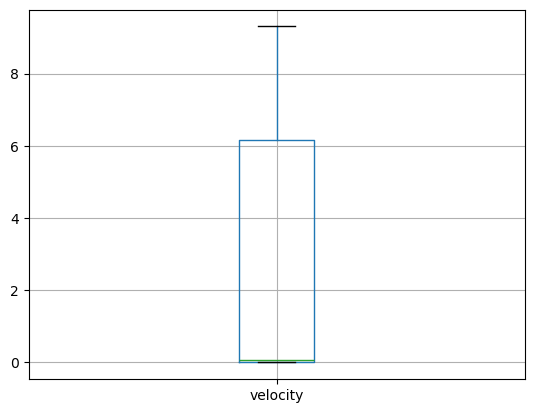

max is: 9.306347735698546
min is: 0.0
(array([731], dtype=int64),)
1135851
716


In [72]:
dfv.loc[:, 'velocity']=dfv.apply(lambda row: velocity_m_per_s(row['previous_latitude'], row['previous_longitude'], row['latitude'], row['longitude'], row['delta_t']), axis=1)
dfv.boxplot(column=['velocity'])
plt.show()
print('max is:', dfv.velocity.max())
print('min is:', dfv.velocity.min())
#print(dfv[dfv.velocity==0].index)
print(np.where(dfv.velocity==0))
print(dfv.velocity.idxmin())
#notice most of the data says the boat is staying still!
print(len(dfv[dfv.velocity<0.05]))

**VesselId** was checked to count how many unique vessels were in the training and test dataset compared to the vessels dataset, and in addition a check was performed to make sure the vesselIds present in X_test were also contained in X_train, and the same was done for X_train and vessels, to make sure there weren't any new ships unknown to the other datasets.

It was also checked that not all obsevations had a valid vesselId, but in the end the decision was taken to ignore these observations, since the model doesn't train on vesselId anyway

In [28]:
# 9 vesselId
print('in the vessel dataset:', vessels.count().iloc[1], '\nin X_train:', df['vesselId'].nunique(), '\nin X_test:', X_test['vesselId'].nunique())
print('are all the vessels in the training dataset inside the vessels too?', set(X_train['vesselId'].unique()).issubset(vessels['vesselId'].unique()))
print('are all the vessels in the test dataset inside the training dataset too?', set(X_test['vesselId'].unique()).issubset(df['vesselId'].unique()))
print('\nnumber of obs with valid vesselId:', df['vesselId'].count(), 'out of', df.shape[0], 'total observations in X_train\n\n')
print('number of NaNs:', df['vesselId'].isna().count())
print((df['vesselId'].isin(["NA", "N/A", "NULL", "None", "", " "]).sum()).sum())
numeric_conversion = pd.to_numeric(df['vesselId'], errors='coerce')
print(numeric_conversion.isna().sum())

in the vessel dataset: 711 
in X_train: 688 
in X_test: 215
are all the vessels in the training dataset inside the vessels too? True
are all the vessels in the test dataset inside the training dataset too? True

number of obs with valid vesselId: 1521395 out of 1521395 total observations in X_train


number of NaNs: 1521395
0
1521395


A similar procedure was done for **PortId**, and we saw that not every port in X_train was contained in the ports dataset too. We pondered, but in the end we ended up not using ports for the model, so we didn't investigate further

In [30]:
# 10 portId
# some missing values values, not sure why, not even sure what form they have
null_values=df[df["portId"].isnull()]
#print(df.shape[0]-df.portId.count())
# 772 unique values, unique ports
print(df.portId.nunique())
print('null values in ports:', null_values['portId'].shape[0])
#it's good that I found the values at least lol
print('in the ports dataset:', ports.count().iloc[0], '\nin X_train:', df['portId'].nunique())
print('are all the ports in the training dataset inside the ports dataset too?', set(X_train['portId'].unique()).issubset(ports['portId'].unique()))
#copies for later
pdf=ports.copy()
vdf=vessels.copy()
#pdf.head()
#vdf.head()
ports.head()


772
null values in ports: 1598
in the ports dataset: 1329 
in X_train: 772
are all the ports in the training dataset inside the ports dataset too? False


,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


### Merging Datasets

At one point it made sense to merge all the datasets all together, so that every observation contained the data on the ship and the port too

In [31]:
#merging all datasets
df = pd.merge(df, vessels, on='vesselId', how='left')
print(df.columns)

Index(['cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portId', 'slow_turn', 'time_int', 'eta_00',
       'eta_int', 'shippingLineId', 'CEU', 'DWT', 'GT', 'NT', 'vesselType',
       'breadth', 'depth', 'draft', 'enginePower', 'freshWater', 'fuel',
       'homePort', 'length', 'maxHeight', 'maxSpeed', 'maxWidth',
       'rampCapacity', 'yearBuilt'],
      dtype='object')


In [32]:
ports.rename(columns={
    'latitude': 'latitude_port',
    'longitude': 'longitude_port'
}, inplace=True)
df = pd.merge(df, ports, on='portId', how='left')
print(df.columns)


Index(['cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portId', 'slow_turn', 'time_int', 'eta_00',
       'eta_int', 'shippingLineId', 'CEU', 'DWT', 'GT', 'NT', 'vesselType',
       'breadth', 'depth', 'draft', 'enginePower', 'freshWater', 'fuel',
       'homePort', 'length', 'maxHeight', 'maxSpeed', 'maxWidth',
       'rampCapacity', 'yearBuilt', 'name', 'portLocation', 'longitude_port',
       'latitude_port', 'UN_LOCODE', 'countryName', 'ISO'],
      dtype='object')


### Visualizing Missing Values

The figure below represents a heatmap of the missing value in the dataset, in yellow the sections where NaNs are present. This helped identify and remove some features that contained too few data to be useful in any situation

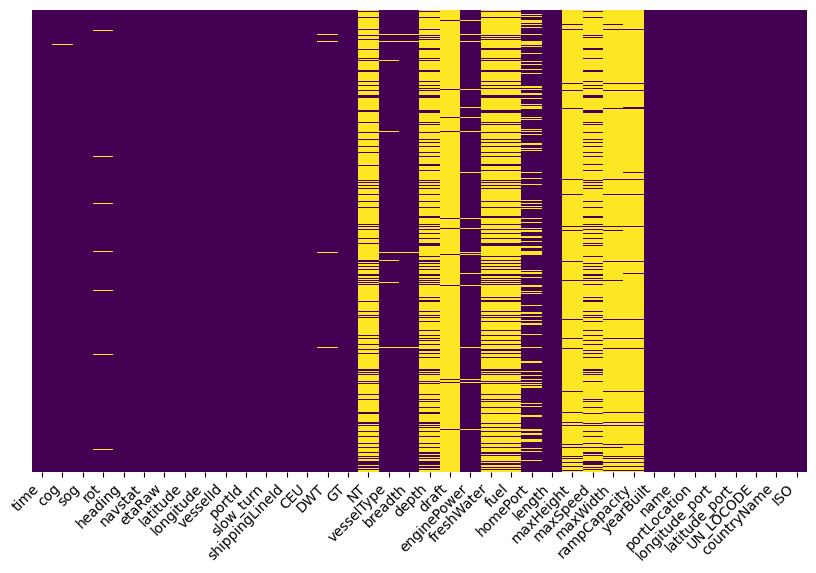

In [34]:
nan_mask = df.isna() 
plt.figure(figsize=(10, 6))  
sns.heatmap(nan_mask, cmap='viridis', cbar=False, yticklabels=False) 
# Rotate x-axis labels 
plt.xticks(rotation=45, ha='right', fontsize=10) 

plt.show() 

### Iterative Imputer 

In this section an iterative imputer was used to address the missing values in the dataset. It's a multivariate imputation algorithm that fills in the missing values in a feature column with a function modeled after other features, and iterates the process multiple times.

In [53]:
# iterative imputer on variables
# vengono sostituiti i NaN con la media dei valori della rispettiva colonna
df_without_time = df.drop(columns=['vesselId', 'portId','time_int', 'eta_00', 'eta_int', 'etaRaw', 'shippingLineId', 'name', 'homePort', 'portLocation', 'UN_LOCODE', 'countryName','ISO', 'NT', 'depth', 'draft', 'freshWater', 'fuel', 'maxHeight', 'maxSpeed', 'maxWidth', 'rampCapacity'])
df_without_time.head()

imputer_coordinates = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer_coordinates.fit_transform(df_without_time), columns=df_without_time.columns)
#imputing only y as it's necessary for the encoders
y_df = df_imputed[['latitude', 'longitude']].copy()

x_df = df[['cog', 'sog', 'rot', 'heading', 'navstat', 'slow_turn', 'CEU', 'DWT', 'GT', 'vesselType', 'breadth', 'enginePower', 'length','yearBuilt', 'latitude_port', 'longitude_port']].copy()
print(y_df.isna().sum())

y_df.head()

latitude     0
longitude    0
dtype: int64


,latitude,longitude
0,-34.74370,-57.85130
1,8.89440,-79.47939
2,39.19065,-76.47567
3,-34.41189,151.02067
4,35.88379,-5.91636


In [19]:
#trasformare le feature che contengono stringhe in interi
categorical_features = ['shippingLineId', 'name', 'homePort', 'portLocation', 'UN_LOCODE', 'countryName','ISO']
encoder_lat = MeanEncoder(variables=categorical_features, missing_values='ignore')
encoder_lon = MeanEncoder(variables=categorical_features, missing_values='ignore')
y_df.head()
df_encoded_lat = encoder_lat.fit_transform(df[categorical_features], y_df['latitude'])
df_encoded_lat.rename(columns={
    'shippingLineId': 'shippingLineId_lat',
    'name': 'name_lat',
    'homePort': 'homePort_lat',
    'homePort': 'homePort_lat',
    'portLocation': 'portLocation_lat',
    'UN_LOCODE': 'UN_LOCODE_lat',
    'countryName': 'countryName_lat',
    'ISO': 'ISO_lat'
}, inplace=True)
df_encoded_lon = encoder_lon.fit_transform(df[categorical_features], y_df['longitude'])
df_encoded_lon.rename(columns={
    'shippingLineId': 'shippingLineId_lon',
    'name': 'name_lon',
    'homePort': 'homePort_lon',
    'homePort': 'homePort_lon',
    'portLocation': 'portLocation_lon',
    'UN_LOCODE': 'UN_LOCODE_lon',
    'countryName': 'countryName_lon',
    'ISO': 'ISO_lon'
}, inplace=True)


df_encoded_lat.head()

C:\python\ml_ntnu\lib\site-packages\feature_engine\encoding\base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) shippingLineId, name, homePort, portLocation, UN_LOCODE, countryName, ISO.
  warnings.warn(
C:\python\ml_ntnu\lib\site-packages\feature_engine\encoding\base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) shippingLineId, name, homePort, portLocation, UN_LOCODE, countryName, ISO.
  warnings.warn(


,shippingLineId_lat,name_lat,homePort_lat,portLocation_lat,UN_LOCODE_lat,countryName_lat,ISO_lat
0,26.278095,10.031987,37.380437,10.031987,10.031987,-1.920953,-1.920953
1,24.321478,8.860111,28.670837,8.860111,8.860111,10.423788,10.423788
2,33.852223,39.338947,NaN,39.338947,39.338947,37.748155,37.748155
3,30.346213,-33.622730,NaN,-33.622730,-33.622730,-30.478795,-30.478795
4,24.321478,35.965411,28.652080,35.965411,35.965411,33.088239,33.088239


In [20]:
#x_df = x_df.drop(categorical_features, axis=1)
x_df = pd.concat([x_df, df_encoded_lat], axis=1)
x_df = pd.concat([x_df, df_encoded_lon], axis=1)

### Correlation Matrix

A **correlation matrix** was created to examine the correlation among all features and identify which ones to remove in order to avoid redundant information. The correlation matrix highlights pairs of feature with high Pearson's correlation coefficient, meaning with high linear correlation. Features that weren't numerical in nature were first encoded. 

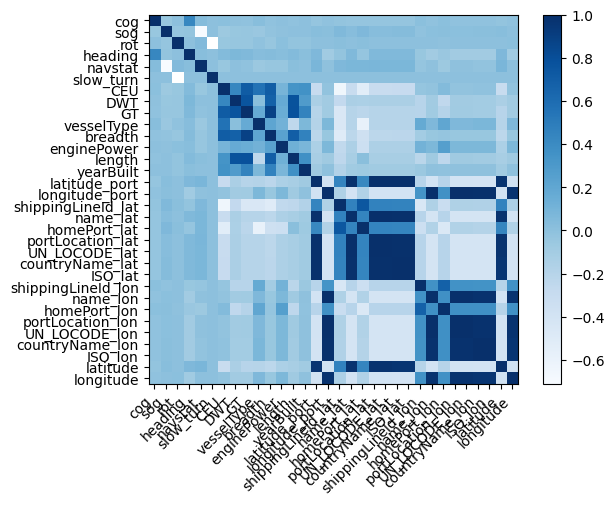

In [21]:
#correlation matrix
dataset = pd.concat([x_df, y_df], axis=1)
matrix = dataset.corr()

plt.imshow(matrix, cmap='Blues')
plt.colorbar()
variables = []
for i in matrix.columns:
    variables.append(i)

plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

plt.show()

Given the presence of highly correlated features in the correlation matrix, a function was created to highlight which pair of features specifically had high correlation to prune the dataset effectively. 

In [37]:
#DROPPING features where we lack too much data
dataset_clean = dataset.drop(columns=['yearBuilt'])

#Dropping features because of high correlation
dataset_clean = dataset_clean.drop(columns=['name_lat', 'portLocation_lat', 'UN_LOCODE_lat', 'countryName_lat', 'ISO_lat', 'name_lon', 'portLocation_lon', 'UN_LOCODE_lon', 'countryName_lon', 'ISO_lon', 'breadth'])

def print_high_correlation_pairs(corr_matrix, threshold):
    # Iterate over the lower triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                feature_1 = corr_matrix.columns[i]
                feature_2 = corr_matrix.columns[j]
                print(f"{feature_1} and {feature_2} have a correlation of {corr_value:.3f}")


print_high_correlation_pairs(dataset_clean.corr(), 0.7)


dataset_clean.to_csv("dataset_reduced_correlation.csv", index=False)


sog and navstat have a correlation of -0.713
CEU and GT have a correlation of 0.711
DWT and GT have a correlation of 0.762
DWT and length have a correlation of 0.774
GT and length have a correlation of 0.783
latitude_port and latitude have a correlation of 0.970
longitude_port and longitude have a correlation of 0.974
shippingLineId_lat and homePort_lat have a correlation of 0.740


## **Feature Engineering**

The first steps in feature engineering were about transforming existents feature into a more suitable form.

The **time** feature was converted to an integer, and the same process was applied to **etaRaw** after setting all non-existent dates, such as 00-00, to NaN. Additionally, it was observed that the dates in ‘etaRaw’ lacked the year, which led to the decision not to use this feature subsequently, as assuming the year to be 2024 was not consistently accurate

In [7]:
df = X_train.copy()
df.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [9]:
# CONVERT TIME INTO INT
df["time"]=pd.to_datetime(df.time)
df['time_int']=df['time'].astype('int64') // 10**9
df=df.drop('time', axis=1)
df.head()

,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,time_int
0,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,1704067225
1,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,1704067236
2,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,1704067305
3,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,1704067391
4,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,1704067431


In [11]:
#Converting etaRaw into int and setting as NaN invalid dates
df["eta_00"]=df["etaRaw"].str[:5];
position=df[df.eta_00=="00-00"].index
print(len(position))

df.loc[df.eta_00=="00-00", "eta_00"]=np.nan
position=df[df.eta_00=="00-00"].index
print(len(position))
df.loc[df.eta_00.isna(), "etaRaw"]=np.nan
print(df["etaRaw"].isna().sum())

year="2024"
df['etaRaw']=year+'-'+df['etaRaw']
df["etaRaw"]=pd.to_datetime(df.etaRaw, errors="coerce")
df['eta_int']=df['etaRaw'].astype('int64') // 10**9
df=df.drop(columns= ['etaRaw','eta_00'])

df.head()


3664
0
3664


,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,time_int,eta_int
0,284.0,0.7,0,88,0,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,1704067225,1704841200
1,109.6,0.0,-6,347,1,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,1704067236,1735502400
2,111.0,11.0,0,112,0,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,1704067305,1704186000
3,96.4,0.0,0,142,1,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,1704067391,1735675200
4,214.0,19.7,0,215,0,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,1704067431,1706184000


**vesselId** was converted into an integer. Instead of converting the string with the corresponding number, an encoder was used to assign numbers from 0 to 688 to the vessels, allowing for smaller numbers and more efficient processing. 

In [13]:
# Initializing LabelEncoder
vessel_encoder = LabelEncoder()
port_encoder = LabelEncoder()

# Fitting e transformation of 'vesselId' e 'portId'
df['vesselId_encoded'] = vessel_encoder.fit_transform(df['vesselId'])
df['portId_encoded'] = port_encoder.fit_transform(df['portId'])

#Saving encoder for future usage
joblib.dump(vessel_encoder, 'vessel_encoder.pkl')
joblib.dump(port_encoder, 'port_encoder.pkl')

df = df.drop(columns = ['vesselId'])
df = df.rename(columns={'vesselId_encoded': 'vesselId'})

df.head()

,cog,sog,rot,heading,navstat,latitude,longitude,portId,time_int,eta_int,vesselId,portId_encoded
0,284.0,0.7,0,88,0,-34.74370,-57.85130,61d371c43aeaecc07011a37f,1704067225,1704841200,50,40
1,109.6,0.0,-6,347,1,8.89440,-79.47939,634c4de270937fc01c3a7689,1704067236,1735502400,189,674
2,111.0,11.0,0,112,0,39.19065,-76.47567,61d3847bb7b7526e1adf3d19,1704067305,1704186000,432,353
3,96.4,0.0,0,142,1,-34.41189,151.02067,61d36f770a1807568ff9a126,1704067391,1735675200,110,18
4,214.0,19.7,0,215,0,35.88379,-5.91636,634c4de270937fc01c3a74f3,1704067431,1706184000,356,605


**PortId** was replaced with the latitude and longitude of the corresponding port. However, since the indicated port could represent either the departure or arrival port, it was ultimately disregarded. 

In [15]:
ports.rename(columns={
    'latitude': 'latitude_port',
    'longitude': 'longitude_port'
}, inplace=True)
df = pd.merge(df, ports[['latitude_port', 'longitude_port', 'portId']], on='portId', how='left')
df=df.drop('portId', axis=1)
df.head()

,cog,sog,rot,heading,navstat,latitude,longitude,time_int,eta_int,vesselId,portId_encoded,latitude_port,longitude_port
0,284.0,0.7,0,88,0,-34.74370,-57.85130,1704067225,1704841200,50,40,-33.5875,-71.618889
1,109.6,0.0,-6,347,1,8.89440,-79.47939,1704067236,1735502400,189,674,8.9670,-79.533000
2,111.0,11.0,0,112,0,39.19065,-76.47567,1704067305,1704186000,432,353,39.2325,-76.558889
3,96.4,0.0,0,142,1,-34.41189,151.02067,1704067391,1735675200,110,18,-34.4625,150.899444
4,214.0,19.7,0,215,0,35.88379,-5.91636,1704067431,1706184000,356,605,35.7830,-5.817000


**delta_time** is a feature that represents the time difference between the current and the previous instant.
The initial instance of each vessel will have an empty delta_time feature.

In [17]:
df['delta_time'] = df.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(1))
df.head()

,cog,sog,rot,heading,navstat,latitude,longitude,time_int,eta_int,vesselId,portId_encoded,latitude_port,longitude_port,delta_time
0,284.0,0.7,0,88,0,-34.74370,-57.85130,1704067225,1704841200,50,40,-33.5875,-71.618889,NaN
1,109.6,0.0,-6,347,1,8.89440,-79.47939,1704067236,1735502400,189,674,8.9670,-79.533000,NaN
2,111.0,11.0,0,112,0,39.19065,-76.47567,1704067305,1704186000,432,353,39.2325,-76.558889,NaN
3,96.4,0.0,0,142,1,-34.41189,151.02067,1704067391,1735675200,110,18,-34.4625,150.899444,NaN
4,214.0,19.7,0,215,0,35.88379,-5.91636,1704067431,1706184000,356,605,35.7830,-5.817000,NaN


Subsequently, new features were considered, calculated using the model's predictions: 

**lat_prev** and **long_prev** are two features created in the training set by including the latitude and longitude of the previous instant for the same vessel. In the test dataset, these columns are populated by using the newly predicted latitude and longitude as the previous coordinates for the following row.

In [19]:
df['lon_prev'] = df.groupby('vesselId')['longitude'].shift(1)
df['lat_prev'] = df.groupby('vesselId')['latitude'].shift(1)

**navstat** is a categorical feature indicating the state of the ship at a certain moment in time. It can be summarized as "moving" or "not moving", so it was turned into a boolean feature 

<Axes: xlabel='navstat', ylabel='count'>

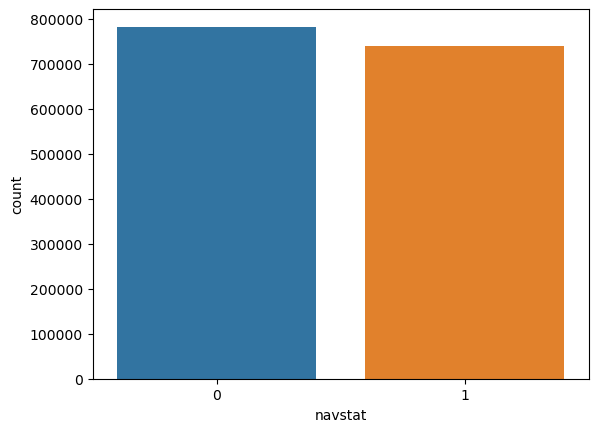

In [21]:
#introduce navstat as 1=stop, 0=movement
df['navstat'] = df['navstat'].apply(lambda x: 1 if x > 0 else x)
sns.countplot(x='navstat', data=df)

the feature **heading** was split into two other boolean features, called **northsouth** and **eastwest**. They represent wether the orginal heading variable was oriented towards up or down, left or right. When using these variables it made sense to drop heading completely after introducing the other two new features

In [23]:
#heading: 2 new columns for up down, left right
df['northsouth']=df['heading'].apply(lambda x: 1 if x <=180 else 0)
df['eastwest']=df['heading'].apply(lambda x: 1 if (x >=270 or x<=90) else 0)
#sns.countplot(x='eastwest', data=df)
#sns.countplot(x='northsouth', data=df)
df = df.drop(columns=['heading'])

**cosine** and **sine** tranformations of the feature cog were also considered for some of the models. By converting the feature from degrees to radiants, and then introducing two new feature representing the values of cosine and sine of cog angle, it was made possible to capture more effecively the information conveyed by the feature cog

In [25]:
def deg_to_rad(ang):
    return ang*2*np.pi/360

def distance_in_meters(lat1, long1, lat2, long2):
    lat1=deg_to_rad(lat1)
    lat2=deg_to_rad(lat2)
    long1=deg_to_rad(long1)
    long2=deg_to_rad(long2)
    a=np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin((long2-long1)/2)**2
    c=2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    #radius of earth in meters
    R=6371000 
    d=R*c
    return d

def calculate_angle(deltax, deltay):
    # Calculate the angle in radians
    angle_rad = math.atan2(deltay, deltax)
    return angle_rad

In [27]:
# Convert 'cog' from degrees to radians
df['cog_rad'] = np.deg2rad(df['cog'])

# Calculate sine and cosine of the angle and add them as new columns
df['sine_cog'] = np.sin(df['cog_rad'])
df['cosine_cog'] = np.cos(df['cog_rad'])

df.drop(columns=['cog_rad','cog'], inplace=True)

**Distance from coast** was another variable that was used while experimenting with feature engineering. The following series of functions were used to calculate this variable. It is important to note that runtime for these functions depends on hardware, and it may take up to 30 minutes to compute.

The process starts with loading a map of the world's coastines from "ne_10m_land.zip", file made available on blackboard. We then lower the resolution of the map to make the calculation easier, and we load the map onto an STRtree. This data structure allows for much faster distance search for each observation of the dataset. A parallelization was also implemented to further improve performance

In [33]:
land = gpd.read_file("ne_10m_land.zip")
land_simplified = land.simplify(tolerance=0.1) 

In [35]:
def build_land_strtree(land_simplified):
    # Flatten MultiPolygons into individual Polygons for indexing
    geometries = [geom for geom in land_simplified.geometry if geom.is_valid]
    return STRtree(geometries), geometries  # Return both the STRtree and geometries for lookup

def calculate_weighted_mean_speed_parallel(data, land_simplified):
    # Build STRtree index for fast nearest-neighbor search
    land_strtree, geometries = build_land_strtree(land_simplified)
    
    def calculate_distance_to_land(lat, lon):
        # Check for valid input types
        if not (isinstance(lat, (float, int)) and isinstance(lon, (float, int))):
            raise TypeError("Latitude and longitude must be numbers.")
        
        point = Point(lon, lat)
        nearest_geom = land_strtree.nearest(point)  # Use STRtree to find the nearest geometry
        return point.distance(nearest_geom)

    with tempfile.TemporaryDirectory() as temp_dir:
        # Apply parallel processing to each row in data
        processed_distances = Parallel(n_jobs=-1, backend='loky', temp_folder=temp_dir)(
            delayed(calculate_distance_to_land)(row['lat_prev'], row['lon_prev']) for _, row in data.iterrows()
        )

    # Convert results to a DataFrame, assuming `data` is also a DataFrame
    result = pd.Series(processed_distances, index=data.index, name="distance_to_land")
    return result

def calculate_distance_from_coast(data, land_simplified):
    # Build STRtree index for fast nearest-neighbor search
    land_strtree, _ = build_land_strtree(land_simplified)
    query_points = np.array([Point(lon, lat) for lat, lon in zip(data['lat_prev'], data['lon_prev'])])
    _, distances = land_strtree.query_nearest(query_points, return_distance=True, all_matches=False)
    return distances


def calculate_distance_from_coast_iter(lat, lon, land_strtree):
    # Build STRtree index for fast nearest-neighbor search
    _, distance = land_strtree.query_nearest(Point(lon, lat), return_distance=True, all_matches=False)
    return distance


def calculate_distance_from_coast_parallel(data, land_simplified):
    # Build STRtree index for fast nearest-neighbor search
    land_strtree, _ = build_land_strtree(land_simplified)
    query_points = np.array([Point(lon, lat) for lat, lon in zip(data['lat_prev'], data['lon_prev'])])
    def query_distance(point):
        _, distance = land_strtree.query_nearest(point, return_distance=True, all_matches=False)
        return distance[0]

    with tempfile.TemporaryDirectory() as temp_dir:
        # Apply parallel processing to each row in data
        processed_distances = Parallel(n_jobs=-1, backend='loky', temp_folder=temp_dir)(
            delayed(query_distance)(point) for point in query_points
        )

    # Convert results to a DataFrame, assuming `data` is also a DataFrame
    result = pd.Series(processed_distances, index=data.index, name="distance_to_land")
    return result

df['distance_from_coast'] = calculate_distance_from_coast_parallel(df, land_simplified)

#### Moored
The moored feature is an example of how domain knowledge research plays an important role in feature engineering. What this feature aims to do is to inform the model on whether or not the vessel is stationary or not through different timestamps. This is trickier then it seems because AIS latitude and longitude tolerances should be accounted for as we do. For the timestamp threshold we use the (discussed later) bayesian optimizator for tuning. From further development the feature didn't make the final cut. 

In [ ]:
fixed_tolerance = 0.0001
def calculate_moored(data, tolerance, timestamp_treshold):
    #global data  # Reference the global variable
    for group_id, group in data.groupby('vesselId'):
            for i in range(timestamp_treshold, len(group)):
                # Get the last x values of latitude and longitude
                lat_values = group['latitude'].iloc[i-timestamp_treshold:i]
                long_values = group['longitude'].iloc[i-timestamp_treshold:i]
                
                # Check if the last x values of latitude and longitude for the specific ID are similar
                if (lat_values.max() - lat_values.min() <= tolerance) and (long_values.max() - long_values.min() <= tolerance):
                    # Update the original DataFrame's moored column
                    data.loc[group.index[i], 'moored'] = 1
    return data

#### Tsfresh features
Given the nature of the task, we  also investigated the use of the *tsfresh package* to extract in a systematic way potentially useful time-series information. The logic being that the subsequent rows of latitude and longitude and all the other features that are time-variant could be seen as time-series and statistical methods could enhance the amount of useful information to be extracted from each feature. With Tsfresh, we were able to test hundreds of different configurations of possible statistically-derived features and then test if they had correlation or not with latitude or longitude. We then used randomforest to make a feature ranking to sort the candidates by relevancy. In the end we didn't move forward with this technique as it seemed like the problem at hand generally rewarded simpler techniques and the models used didn't seem to benefit eccessively from re-engineering existing information, but instead it seemed to be more important to find ways to add as much as new relevant information as possible. 

In [ ]:
extracted_features = extract_features(dataset, column_id="vesselId", column_sort="time_int")
impute(extracted_features)
features_filtered_lat_sum = select_features(extracted_features, y_lat)
ranking_model = RandomForestRegressor(n_estimators=100, random_state=42)
ranking_model.fit(features_filtered_lat, y_lat)
importances = ranking_model.feature_importances_
feature_names = importances.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#### Bayesian optimization for optimal placement of time instants
Further down development, it became apparent that the most rewarding road for making better models was to focus on only the delta-time between the current time and the time from the previous data-point of that vessel and the previous latitude and longitude. Expanding from this concept we added the same information from different previous timestamps based on this:

In [ ]:
df['time_zeroed'] = df.groupby('vesselId')['time_int'].transform(lambda x: x - x.iloc[0])
threshold_1_hour = 3600
threshold_1_day = 1*24*3600
threshold_1_25_days = 151200
threshold_2_5_days = 216000
count_3_75_days = 324000
threshold_5_days = 432000

# Count rows where `time_zeroed` is less than the thresholds, per vesselId
threshold_1_hour = round(df.groupby('vesselId')['time_zeroed'].apply(lambda x: (x < threshold_1_hour).sum()).mean())
count_1_day = round(df.groupby('vesselId')['time_zeroed'].apply(lambda x: (x < threshold_1_day).sum()).mean())
count_1_25_days = round(df.groupby('vesselId')['time_zeroed'].apply(lambda x: (x < threshold_1_25_days).sum()).mean())
count_2_5_days = round(df.groupby('vesselId')['time_zeroed'].apply(lambda x: (x < threshold_2_5_days).sum()).mean())
count_3_75_days = round(df.groupby('vesselId')['time_zeroed'].apply(lambda x: (x < count_3_75_days).sum()).mean())
count_5_days = round(df.groupby('vesselId')['time_zeroed'].apply(lambda x: (x < threshold_5_days).sum()).mean())
count_5 = np.array(round(df.groupby('vesselId')['time_zeroed'].apply(lambda x: (x < threshold_5_days).mean())))
count_max = df.groupby('vesselId').sum().min()

We also noticed that there was a big discrepancy in the resulting score between the values calculated by using mean and by using median. This was problably due to a significant presence or severity of outliers in the number of timestamps that fell under those categories for each vessel. This prompted us to investigate the concept further by using bayesian optimization to search for the best combination of previous timestamps to be used given the dataset.

In [ ]:
class WeightedMeanOptimizer:
    def __init__(self, data, target_cols=['latitude', 'longitude'], scoring='neg_mean_squared_error'):
        self.data = data.copy()
        self.target_cols = target_cols
        self.scoring = scoring

    def objective(self, o2, o3, o4, o5):
        # here we defined the constraints by remapping parameters in a way that 2<=offset2<offset3<offset4<offset5<=150
        offset2 = round(2 + (150 - 5)*o2)
        offset5 = round(offset2 + 3 + (150 - offset2 - 3)*o5)
        offset3 = round(offset2 + 1 + (offset5 - offset2 - 3)*o3)
        offset4 = round(offset3 + 1 + (offset5 - offset3 - 2)*o4)
        
        
        data = self.data.copy()
        data['lon_prev2'] = data.groupby('vesselId')['longitude'].shift(offset2)
        data['lat_prev2'] = data.groupby('vesselId')['latitude'].shift(offset2)
        data['time_int_prev2'] = data.groupby('vesselId')['time_int'].shift(offset2)
        data['delta_time2'] = data.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(offset2))
        
        data['lon_prev3'] = data.groupby('vesselId')['longitude'].shift(offset3)
        data['lat_prev3'] = data.groupby('vesselId')['latitude'].shift(offset3)
        data['delta_time3'] = data.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(offset3))
        
        data['lon_prev4'] = data.groupby('vesselId')['longitude'].shift(offset4)
        data['lat_prev4'] = data.groupby('vesselId')['latitude'].shift(offset4)
        data['delta_time4'] = data.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(offset4))
        
        data['lon_prev5'] = data.groupby('vesselId')['longitude'].shift(offset5)
        data['lat_prev5'] = data.groupby('vesselId')['latitude'].shift(offset5)
        data['delta_time5'] = data.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(offset5))
        
        data.dropna(inplace=True)
        
        total_features = data.columns.to_list()
        y_features = ['latitude', 'longitude']
        features_to_remove_from_x = y_features + ['latitude_port', 'longitude_port', 'vesselId', 'time_int', 'delta_time_prev', 'portId', 'time_int_prev2']
        total_features = [feature for feature in total_features if feature not in features_to_remove_from_x]
        
        y = data[y_features]
        X = data[total_features]

        # Model definition and scoring
        model = RandomForestRegressor(n_jobs =-1, max_depth=80, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=20, random_state = 42, verbose = 0)

        # Cross-validation
        score = -cross_val_score(model, X, y, cv=4, scoring=self.scoring, n_jobs=-1).mean()
        
        return score

optimizer = WeightedMeanOptimizer(data)

pbounds = {
    'o2': (0, 1), #timestamp offsets of the data to be included in the dataset (latitude, longitude and delta time) normalized
    'o3': (0, 1),
    'o4': (0, 1),
    'o5': (0, 1)
}

bayes_opt = BayesianOptimization(
    f=optimizer.objective,
    pbounds=pbounds,
    random_state=42
)
kernel_matern = Matern(length_scale=1.0, nu=0.5)  #used matern kernel with low nu to take into account the non-derivability of the target function
bayes_opt.set_gp_params(kernel=kernel_matern)
bayes_opt.maximize(init_points=5, n_iter=50)

print("Best parameters:", bayes_opt.max['params'])
print("Best score:", bayes_opt.max['target'])

Here, the values of o2, o3, o4, o5 can be convered to the number of previous timestamps to look for between 2 and 150. A higher value translates in older data. We used this optimization as an indication that focusing on older data rather then more recent data was more beneficial for effective regression. In particular the neighborhood between 123 and 130 seemed to be optimal.

## **Models Used**

The following are callable function to train models that were used for our project. Mainly, three types of models have been used: XGBoost, Random Forest and Extra Trees.

**XGBoost** gave consistently worse results when using the same features as the other models, but was considerably faster to train, meaning that it could be used to test efficiently new combinations of features without taking up too much time. We also used extensively hyperparameter optimization.

**Random Forest** has consistently been giving the lowest scores. Anything that produced an improvement with XGBoost was subsequently tested on Random Forest to get a better score. In the end it turned out to be the model chosen for the submissions. We employed hyperparameter optimization to get better results.

**Extra Trees** was used as an experimental alternative to random forest. In theory it should produce results with lower variance, which is desirable in the context of the project as the private score is unknown and can vary compare to the public score

A variable called **train_new_model** was introduced as a flag to signal wether or not to train a new model when running the code. The library joblib was also used to save the model locally to avoid having to re-train them every time.

#### Why those hyperparameters?
All hyperparameter sets we employ on every model where discovered through bayessearch-based hyperparameter optimization, combined with educated guesses if warranted. For further information on the specifics of the matter there is a paragraph below that covers it. 

In [ ]:
train_new_model=True

def train_model_randomforest(X_train, y_train):
        rf_model = RandomForestRegressor(n_jobs =-1, max_depth=80, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=20, random_state = 42, verbose = 0)
        rf_model.feature_names = list(X_train.columns.values)
        rf_model.fit(X_train, y_train)
        joblib.dump(rf_model, 'rf_model_old_opt.joblib')
        return rf_model

def train_model_extratrees(X_train, y_train):
    et_model = ExtraTreesRegressor(n_jobs =-1, max_depth=80, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=20, random_state = 42, verbose = 0)
    et_model.feature_names = list(X_train.columns.values)
    et_model.fit(X_train, y_train)
    joblib.dump(et_model, 'et_model_test.joblib')
    return et_model

def train_model_xgboost(X_train, y_train):
        xgb_model = XGBRegressor(alpha=0, booster='dart', eta=0.2818541341504961, reg_lambda=0, max_depth=15, min_child_weight=0, subsample=1.0, random_state=42, n_jobs=-1, verbosity=2)
        xgb_model.feature_names = list(X_train.columns.values)
        xgb_model.fit(X_train, y_train)
        joblib.dump(xgb_model, 'xgb_model.joblib')
        return xgb_model

if train_new_model:
        model = train_model_randomforest(Xtrain, ytrain)
else:
    try:
        model = joblib.load('model.joblib')
    except FileNotFoundError:
        print("No existing xgb_model found, training a new one")
        model = train_model(Xtrain, ytrain)

The **cycle function** takes as input a model, a training set, and a test set for prediction. It creates a dictionary that stores the last known values for each vessel. Based on these values, the model predicts the latitude and longitude at the next time step, and these new values are then saved in the dictionary, replacing the previous ones to facilitate predictions for the subsequent time step, and so on. In the end, the function returns the predicted latitude and longitude values.

In [ ]:
def cycle(model, X_test, df):
    # Predict latitude and longitude

    # Initialize the features prev_latitude and prev_longitude in the test dataset with NaN
    X_test['lat_prev'] = np.nan
    X_test['lon_prev'] = np.nan
    X_test['delta_time'] = np.nan
    
    # Dictionary to hold the last known lat/lon for each vessel from the training set
    vessel_last_positions = df[['vesselId', 'latitude', 'longitude', 'time_int']].groupby('vesselId').last().to_dict(orient='index')
    # Lists to store predictions
    predicted_lat = []
    predicted_lon = []
    
    # Loop through each row in the sorted X_test
    for i, row in X_test.iterrows():
        vessel_id = row['vesselId']
        
        # Initialize prev_lat and prev_lon for this vessel
        row['lat_prev'] = vessel_last_positions[vessel_id]['latitude']
        row['lon_prev'] = vessel_last_positions[vessel_id]['longitude']
        row['delta_time'] = row['time_int'] - vessel_last_positions[vessel_id]['time_int']
        
        # Reorder the row to match the feature order expected by the model
        row_reordered = row[model.feature_names]  # Ensure correct feature order
        row_np = np.array(row_reordered).reshape(1, -1)  # Reshape to (1, 5)
        #row_df = pd.DataFrame(row_reordered)
        row_df = pd.DataFrame(row_np, columns=['lon_prev', 'lat_prev', 'delta_time'])


        #print(type(row_np))
        # Predict latitude and longitude
        pred = model.predict(row_df)
        
        # Assuming the model outputs a 2D array, where pred[0][0] is latitude and pred[0][1] is longitude
        predicted_lat.append(pred[0][0])
        predicted_lon.append(pred[0][1])
        
        # Update prev_latitude and prev_longitude in the vessel_last_positions dictionary
        vessel_last_positions[vessel_id] = {'latitude': pred[0][0], 'longitude': pred[0][1], 'time_int': row['time_int']}

    return predicted_lat, predicted_lon

An attempt was made to consider the coordinates at multiple previous time points.

In [ ]:
def cycle(model, X_test, df):
    # Predict latitude and longitude

    # Initialize the features prev_latitude and prev_longitude in the test dataset with NaN
    X_test['lat_prev'] = np.nan
    X_test['lon_prev'] = np.nan
    X_test['lat_prev2'] = np.nan
    X_test['lon_prev2'] = np.nan
    X_test['lat_prev3'] = np.nan
    X_test['lon_prev3'] = np.nan
    X_test['delta_time'] = np.nan
    X_test['delta_time2'] = np.nan
    X_test['delta_time3'] = np.nan

    
    # Dictionary to hold the last known lat/lon for each vessel from the training set
    vessel_last_positions = df[['vesselId', 'latitude', 'longitude', 'time_int']].groupby('vesselId').last().to_dict(orient='index')
    vessel_last_positions2 = df[['vesselId', 'lat_prev', 'lon_prev', 'time_int_prev']].groupby('vesselId').last().to_dict(orient='index')
    vessel_last_positions3 = df[['vesselId', 'lat_prev2', 'lon_prev2', 'time_int_prev2']].groupby('vesselId').last().to_dict(orient='index')
    # Lists to store predictions
    predicted_lat = []
    predicted_lon = []
    
    # Loop through each row in the sorted X_test
    for i, row in X_test.iterrows():
        vessel_id = row['vesselId']
        
        # Initialize prev_lat and prev_lon for this vessel
        row['lat_prev'] = vessel_last_positions[vessel_id]['latitude']
        row['lon_prev'] = vessel_last_positions[vessel_id]['longitude']
        row['lat_prev2'] = vessel_last_positions2[vessel_id]['lat_prev']
        row['lon_prev2'] = vessel_last_positions2[vessel_id]['lon_prev']
        row['lat_prev3'] = vessel_last_positions3[vessel_id]['lat_prev2']
        row['lon_prev3'] = vessel_last_positions3[vessel_id]['lon_prev2']
        row['delta_time'] = row['time_int'] - vessel_last_positions[vessel_id]['time_int']
        row['delta_time2'] = vessel_last_positions[vessel_id]['time_int'] - vessel_last_positions2[vessel_id]['time_int_prev']
        row['delta_time3'] = vessel_last_positions2[vessel_id]['time_int_prev'] - vessel_last_positions3[vessel_id]['time_int_prev2']
        row['time_int_prev'] = vessel_last_positions[vessel_id]['time_int']
        row['time_int_prev2'] = vessel_last_positions2[vessel_id]['time_int_prev']
        
        # Reorder the row to match the feature order expected by the model
        row_reordered = row[model.feature_names]  # Ensure correct feature order
        row_np = np.array(row_reordered).reshape(1, -1)  # Reshape to (1, 5)
        
        # Predict latitude and longitude
        pred = model.predict(row_np)
        
        # Assuming the model outputs a 2D array, where pred[0][0] is latitude and pred[0][1] is longitude
        predicted_lat.append(pred[0][0])
        predicted_lon.append(pred[0][1])
        
        # Update prev_latitude and prev_longitude in the vessel_last_positions dictionary
        vessel_last_positions2[vessel_id] = {'lat_prev2': row['lat_prev2'], 'lon_prev2': row['lon_prev2'], 'time_int_prev2': vessel_last_positions2[vessel_id]['time_int_prev']}
        vessel_last_positions2[vessel_id] = {'lat_prev': row['lat_prev'], 'lon_prev': row['lon_prev'], 'time_int_prev': vessel_last_positions[vessel_id]['time_int']}
        vessel_last_positions[vessel_id] = {'latitude': pred[0][0], 'longitude': pred[0][1], 'time_int': row['time_int']}

    return predicted_lat, predicted_lon

The final version of the cycle function we used allows for selecting different time points in the past, up to five days prior. We chose to take one time point per day, estimating approximately how many samples back we needed to retrieve.

In [ ]:
N=np.array([1, 72, 99, 124, 127, 130])

df['lon_prev'] = df.groupby('vesselId')['longitude'].shift(N[0])
df['lat_prev'] = df.groupby('vesselId')['latitude'].shift(N[0])
df['time_int_prev'] = df.groupby('vesselId')['time_int'].shift(N[0])
df['delta_time'] = df.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(N[0]))
df['lon_prev2'] = df.groupby('vesselId')['longitude'].shift(N[1])
df['lat_prev2'] = df.groupby('vesselId')['latitude'].shift(N[1])
df['time_int_prev2'] = df.groupby('vesselId')['time_int'].shift(N[1])
df['delta_time2'] = df.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(N[1]))
df['lon_prev3'] = df.groupby('vesselId')['longitude'].shift(N[2])
df['lat_prev3'] = df.groupby('vesselId')['latitude'].shift(N[2])
df['delta_time3'] = df.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(N[2]))
df['lon_prev4'] = df.groupby('vesselId')['longitude'].shift(N[3])
df['lat_prev4'] = df.groupby('vesselId')['latitude'].shift(N[3])
df['delta_time4'] = df.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(N[3]))
df['lon_prev5'] = df.groupby('vesselId')['longitude'].shift(N[4])
df['lat_prev5'] = df.groupby('vesselId')['latitude'].shift(N[4])
df['delta_time5'] = df.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(N[4]))
df['lon_prev6'] = df.groupby('vesselId')['longitude'].shift(N[5])
df['lat_prev6'] = df.groupby('vesselId')['latitude'].shift(N[5])
df['delta_time6'] = df.groupby('vesselId')['time_int'].transform(lambda x: x - x.shift(N[5]))
df.head()

In [ ]:
def cycle(model, X_test, df, N):
    # Predict latitude and longitude

    data = {}
    for vessel_id, group in df.groupby('vesselId'):
        # Each group becomes a list of tuples (lat_prev, lon_prev, time_int)
        data[vessel_id] = list(zip(group['lat_prev'], group['lon_prev'], group['time_int']))

    # Initialize the features prev_latitude and prev_longitude in the test dataset with NaN
    X_test['lat_prev'] = np.nan
    X_test['lon_prev'] = np.nan
    X_test['delta_time'] = np.nan
    X_test['lat_prev2'] = np.nan
    X_test['lon_prev2'] = np.nan
    X_test['delta_time2'] = np.nan
    X_test['lat_prev3'] = np.nan
    X_test['lon_prev3'] = np.nan
    X_test['delta_time3'] = np.nan
    X_test['lat_prev4'] = np.nan
    X_test['lon_prev4'] = np.nan
    X_test['delta_time4'] = np.nan
    X_test['lat_prev5'] = np.nan
    X_test['lon_prev5'] = np.nan
    X_test['delta_time5'] = np.nan
    X_test['lat_prev6'] = np.nan
    X_test['lon_prev6'] = np.nan
    X_test['delta_time6'] = np.nan
    
    
    
    # Dictionary to hold the last known lat/lon for each vessel from the training set
    vessel_last_positions = df[['vesselId', 'latitude', 'longitude', 'time_int']].groupby('vesselId').last().to_dict(orient='index')
    # Lists to store predictions
    predicted_lat = []
    predicted_lon = []

    total_rows = len(X_test)
    increment = total_rows // 10  # Calculate the row count for 10% increments
    # Loop through each row in the sorted X_test
    for i, row in X_test.iterrows():
        if i % increment == 0 and i > 0:
           print(f"Processing: {i / total_rows * 100:.0f}% completed.")

        vessel_id = row['vesselId']

    
        index_offset2 = len(data[vessel_id]) - N[1]
        index_offset3 = len(data[vessel_id]) - N[2]
        index_offset4 = len(data[vessel_id]) - N[3]
        index_offset5 = len(data[vessel_id]) - N[4]
        index_offset6 = len(data[vessel_id]) - N[5]


        # Initialize prev_lat and prev_lon for this vessel
        row['lat_prev'] = vessel_last_positions[vessel_id]['latitude']
        row['lon_prev'] = vessel_last_positions[vessel_id]['longitude']
        row['delta_time'] = row['time_int'] - vessel_last_positions[vessel_id]['time_int']
        row['lat_prev2'] = data[vessel_id][index_offset2][0]
        row['lon_prev2'] = data[vessel_id][index_offset2][1]
        row['delta_time2'] = row['time_int'] - data[vessel_id][index_offset2][2]
        row['lat_prev3'] = data[vessel_id][index_offset3][0]
        row['lon_prev3'] = data[vessel_id][index_offset3][1]
        row['delta_time3'] = row['time_int'] - data[vessel_id][index_offset3][2]
        row['lat_prev4'] = data[vessel_id][index_offset4][0]
        row['lon_prev4'] = data[vessel_id][index_offset4][1]
        row['delta_time4'] = row['time_int'] - data[vessel_id][index_offset4][2]
        row['lat_prev5'] = data[vessel_id][index_offset5][0]
        row['lon_prev5'] = data[vessel_id][index_offset5][1]
        row['delta_time5'] = row['time_int'] - data[vessel_id][index_offset5][2]
        row['lat_prev6'] = data[vessel_id][index_offset6][0]
        row['lon_prev6'] = data[vessel_id][index_offset6][1]
        row['delta_time6'] = row['time_int'] - data[vessel_id][index_offset6][2]
        
        
        # Reorder the row to match the feature order expected by the model
        row_reordered = row[model.feature_names]  # Ensure correct feature order
        row_df = pd.DataFrame([row_reordered], columns=model.feature_names_in_)

        # Predict latitude and longitude
        pred = model.predict(row_df)
        
        # Assuming the model outputs a 2D array, where pred[0][0] is latitude and pred[0][1] is longitude
        predicted_lat.append(pred[0][0])
        predicted_lon.append(pred[0][1])
        
        # Update prev_latitude and prev_longitude in the vessel_last_positions dictionary
        vessel_last_positions[vessel_id] = {'latitude': pred[0][0], 'longitude': pred[0][1], 'time_int': row['time_int']}
        data[vessel_id].append((pred[0][0], pred[0][1], row['time_int']))

    return predicted_lat, predicted_lon

An attempt was also made to include SOG among the predicted features and to add past SOG values plus other additional features described under the feature engineering section

In [ ]:
def cycle(model, X_test, df, N):
    # Predict latitude and longitude

    data = {}
    for vessel_id, group in df.groupby('vesselId'):
        # Each group becomes a list of tuples (lat_prev, lon_prev, time_int)
        data[vessel_id] = list(zip(group['lat_prev'], group['lon_prev'], group['time_int'], group['sog_prev'], 
                                   group['navstat'], group['northsouth'], group['eastwest']))

    # Initialize the features prev_latitude and prev_longitude in the test dataset with NaN
    X_test['lat_prev'] = np.nan
    X_test['lon_prev'] = np.nan
    X_test['delta_time'] = np.nan
    X_test['lat_prev2'] = np.nan
    X_test['lon_prev2'] = np.nan
    X_test['delta_time2'] = np.nan
    X_test['lat_prev3'] = np.nan
    X_test['lon_prev3'] = np.nan
    X_test['delta_time3'] = np.nan
    X_test['lat_prev4'] = np.nan
    X_test['lon_prev4'] = np.nan
    X_test['delta_time4'] = np.nan
    X_test['lat_prev5'] = np.nan
    X_test['lon_prev5'] = np.nan
    X_test['delta_time5'] = np.nan
    X_test['sog_prev'] = np.nan
    X_test['sog_prev2'] = np.nan
    X_test['sog_prev3'] = np.nan
    X_test['sog_prev4'] = np.nan
    X_test['sog_prev5'] = np.nan
    X_test['navstat'] = np.nan
    X_test['northsouth'] = np.nan
    X_test['eastwest'] = np.nan
    X_test['distance_from_coast'] = np.nan
    X_test['sine_cog'] = np.nan
    X_test['cosine_cog'] = np.nan
    
    
    
    # Dictionary to hold the last known lat/lon for each vessel from the training set
    vessel_last_positions = df[['vesselId', 'latitude', 'longitude', 'time_int', 'sog', 'navstat', 'northsouth', 'eastwest', 'sine_cog', 'cosine_cog']].groupby('vesselId').last().to_dict(orient='index')
    
    # Lists to store predictions
    predicted_lat = []
    predicted_lon = []
    predicted_sog = []

    #strtree to search closest coast
    land = gpd.read_file("ne_10m_land.zip") #imports data
    land_simplified = land.simplify(tolerance=0.1) #simplifies the geometry to a lower resolution
    land_strtree, _ = build_land_strtree(land_simplified) #builds tree for quicker distance calculation
    
    total_rows = len(X_test)
    increment = total_rows // 10  # Calculate the row count for 10% increments
    # Loop through each row in the sorted X_test
    for i, row in X_test.iterrows():
        if i % increment == 0 and i > 0:
           print(f"Processing: {i / total_rows * 100:.0f}% completed.")

        vessel_id = row['vesselId']
        #print(vessel_id)
        index_offset2 = len(data[vessel_id]) - N[1]
        index_offset3 = len(data[vessel_id]) - N[2]
        index_offset4 = len(data[vessel_id]) - N[3]
        index_offset5 = len(data[vessel_id]) - N[4]
        
        
        # Initialize prev_lat and prev_lon for this vessel
        row['lat_prev'] = vessel_last_positions[vessel_id]['latitude']
        row['lon_prev'] = vessel_last_positions[vessel_id]['longitude']
        row['delta_time'] = row['time_int'] - vessel_last_positions[vessel_id]['time_int']
        row['lat_prev2'] = data[vessel_id][index_offset2][0]
        row['lon_prev2'] = data[vessel_id][index_offset2][1]
        row['delta_time2'] = row['time_int'] - data[vessel_id][index_offset2][2]
        row['lat_prev3'] = data[vessel_id][index_offset3][0]
        row['lon_prev3'] = data[vessel_id][index_offset3][1]
        row['delta_time3'] = row['time_int'] - data[vessel_id][index_offset3][2]
        row['lat_prev4'] = data[vessel_id][index_offset4][0]
        row['lon_prev4'] = data[vessel_id][index_offset4][1]
        row['delta_time4'] = row['time_int'] - data[vessel_id][index_offset4][2]
        row['lat_prev5'] = data[vessel_id][index_offset5][0]
        row['lon_prev5'] = data[vessel_id][index_offset5][1]
        row['delta_time5'] = row['time_int'] - data[vessel_id][index_offset5][2]
        #initialize sog
        row['sog_prev'] = vessel_last_positions[vessel_id]['sog']
        row['sog_prev2'] = data[vessel_id][index_offset2][2]
        row['sog_prev3'] = data[vessel_id][index_offset3][2]
        row['sog_prev4'] = data[vessel_id][index_offset4][2]
        row['sog_prev5'] = data[vessel_id][index_offset5][2]
        #initialize the other features
        row['navstat'] = vessel_last_positions[vessel_id]['sog']
        row['northsouth'] = vessel_last_positions[vessel_id]['northsouth']
        row['eastwest'] = vessel_last_positions[vessel_id]['eastwest']
        #initialize the distance from coast
        row['distance_from_coast'] = calculate_distance_from_coast_iter(vessel_last_positions[vessel_id]['latitude'], vessel_last_positions[vessel_id]['longitude'], land_strtree)
        #initialize cos and sin of cog
        row['sine_cog'] = vessel_last_positions[vessel_id]['sine_cog']
        row['cosine_cog'] = vessel_last_positions[vessel_id]['cosine_cog']
        
        # Reorder the row to match the feature order expected by the model
        row_reordered = row[model.feature_names]  # Ensure correct feature order
        row_df = pd.DataFrame([row_reordered], columns=model.feature_names_in_)

        # Predict latitude and longitude
        pred = model.predict(row_df)
        
        # Assuming the model outputs a 2D array, where pred[0][0] is latitude and pred[0][1] is longitude
        predicted_lat.append(pred[0][0])
        predicted_lon.append(pred[0][1])
        predicted_sog.append(pred[0][2])

        #update sin and cos
        lat1= row['lat_prev']
        lat2 = pred[0][0]
        delta_lat = distance_in_meters(lat1, 0, lat2, 0)

        long1 = row['lon_prev']
        long2 = pred[0][1]
        delta_long = distance_in_meters(0, long1, 0, long2)

        cog_rad = calculate_angle(delta_long, delta_lat)
        
        # Calculate sine and cosine of the angle and add them as new columns
        sine_cog = np.sin(cog_rad)
        cosine_cog = np.cos(cog_rad)
        
        # update the other features
        n= 0 if pred[0][2] <= 0.6 else 1
        ns= 1 if (pred[0][0]-row['lat_prev'] > 0) else 0
        ew= 1 if (pred[0][1]-row['lon_prev'] > 0) else 0
        #print(ns)
        #print(vessel_last_positions[vessel_id]['northsouth'])
        # Update prev_latitude and prev_longitude in the vessel_last_positions dictionary
        vessel_last_positions[vessel_id] = {'latitude': pred[0][0], 'longitude': pred[0][1], 'time_int': row['time_int'], 'sog': pred[0][2], 'eastwest': ew, 'navstat': n, 'northsouth': ns, 'sine_cog': sine_cog, 'cosine_cog': cosine_cog}
        data[vessel_id].append((pred[0][0], pred[0][1], row['time_int']))
    

    return predicted_lat, predicted_lon

## **Hyperparameter optimization**
We aggressively ran hyperoptimizations for both Xgboost and randomforest models. At the start, we adopted gridsearchCV for a gridsearch of randomforest hyperparameters of a model using a dataset obtained by pruning all features that either had a prevalence of Nan values or had a very high correlation between each other. This first optimization taught us that we had to be more careful with the hyperparameters to optimize as some might have low relevance for the problem at hand and or might mean exponentially longer time to complete the optimization. Also, we decided to pivot to BayessearchCV as, even though it was trickier to manage, for searching big param-grids it's much more efficient.

In [ ]:
def tune_random_forest_bayesian(X_train, y_train, model_save_path='best_rf_model_bayesian.joblib'):
    # Set up the parameter search space
    param_space = {
        'n_estimators': (20,110),                # Range of n_estimators
        'max_depth': (80, 110),                     # Range of max_depth
        'min_samples_split': (2, 5),               # Range of min_samples_split
        'min_samples_leaf': (1, 5),                 # Range of min_samples_leaf
        'min_weight_fraction_leaf' :(0, 0.5)
    }
    
    # Initialize the RandomForestRegressor
    rf = RandomForestRegressor(random_state=42,n_jobs = 3)

    # Initialize the BayesSearchCV object
    bayes_search = BayesSearchCV(estimator=rf, search_spaces=param_space, 
                                 n_iter=32, cv=5, n_jobs=1, verbose=2, 
                                 scoring='neg_median_absolute_error')
    
    try:
        # Fit the BayesSearchCV to the training data
        bayes_search.fit(X_train, y_train)
        
    except KeyboardInterrupt:
        print("Keyboard interrupt detected. Saving the best model found so far...")
        if hasattr(bayes_search, 'best_estimator_'):
            rf_model = bayes_search.best_estimator_
            rf_model.feature_names = list(X_train.columns.values)
            joblib.dump(rf_model, model_save_path)
        raise  # Re-raise the KeyboardInterrupt to stop execution

    except Exception as e:
        print(f"An error occurred: {e}")
        print("Saving the best model found so far...")
        # Save the best model found so far
        if hasattr(bayes_search, 'best_estimator_'):
            rf_model = bayes_search.best_estimator_
            rf_model.feature_names = list(Xtrain.columns.values)
            joblib.dump(rf_model, model_save_path)
        raise  # Re-raise the exception after saving

    finally:
        # Save the best model to disk when the process completes successfully
        print("Saving the final best model...")
        if hasattr(bayes_search, 'best_estimator_'):
            rf_model = bayes_search.best_estimator_
            rf_model.feature_names = list(Xtrain.columns.values)
            joblib.dump(rf_model, model_save_path)
            joblib.dump(bayes_search.best_params_, "params_searched.joblib")

    # Return the best model and parameters
    return bayes_search.best_estimator_, bayes_search.best_params_

We were always running hyperoptimizations on the latest best model and dataset pair simultaniusly to continuing developing the taks, also trying hyperparameter configurations obtained mid-optimization. It proved critical to selectan appropriate number of iterations to make sure the bayessearch converged but to not take too. That said, running "additive" hyperparameter optimizations on models that where already using a set of optimally selected hyperparameters didn't prove beneficial. 


## **Feature Importance**


After training the models, the focus shifted towards understanding and analysing the models that were produced. XGBoost and Random Forest have a built-in function that calculates feature importance based on weight, meaning how often the feature appears in splits in the model. What has been observed is that longitude of lag 1 takes up close to 90% of the feature importance of almost eveyr model that has been created during this project. A hypothesis on the reason why has been formulated, as it may have to do with the fact that most long ship travels occur along longitude and not latitude, meaning horizontally, as they move from one continent to another

In [13]:
importances_var = model.feature_importances_
feature_names = Xtrain.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_var})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

        Feature  Importance
0      lon_prev    0.934055
1      lat_prev    0.061421
2    delta_time    0.004075
9     lon_prev4    0.000051
3     lon_prev2    0.000050
4     lat_prev2    0.000040
5   delta_time2    0.000037
7     lat_prev3    0.000035
10    lat_prev4    0.000034
6     lon_prev3    0.000031
8   delta_time3    0.000026
16    lat_prev6    0.000026
13    lat_prev5    0.000024
17  delta_time6    0.000022
12    lon_prev5    0.000021
14  delta_time5    0.000019
11  delta_time4    0.000018
15    lon_prev6    0.000015


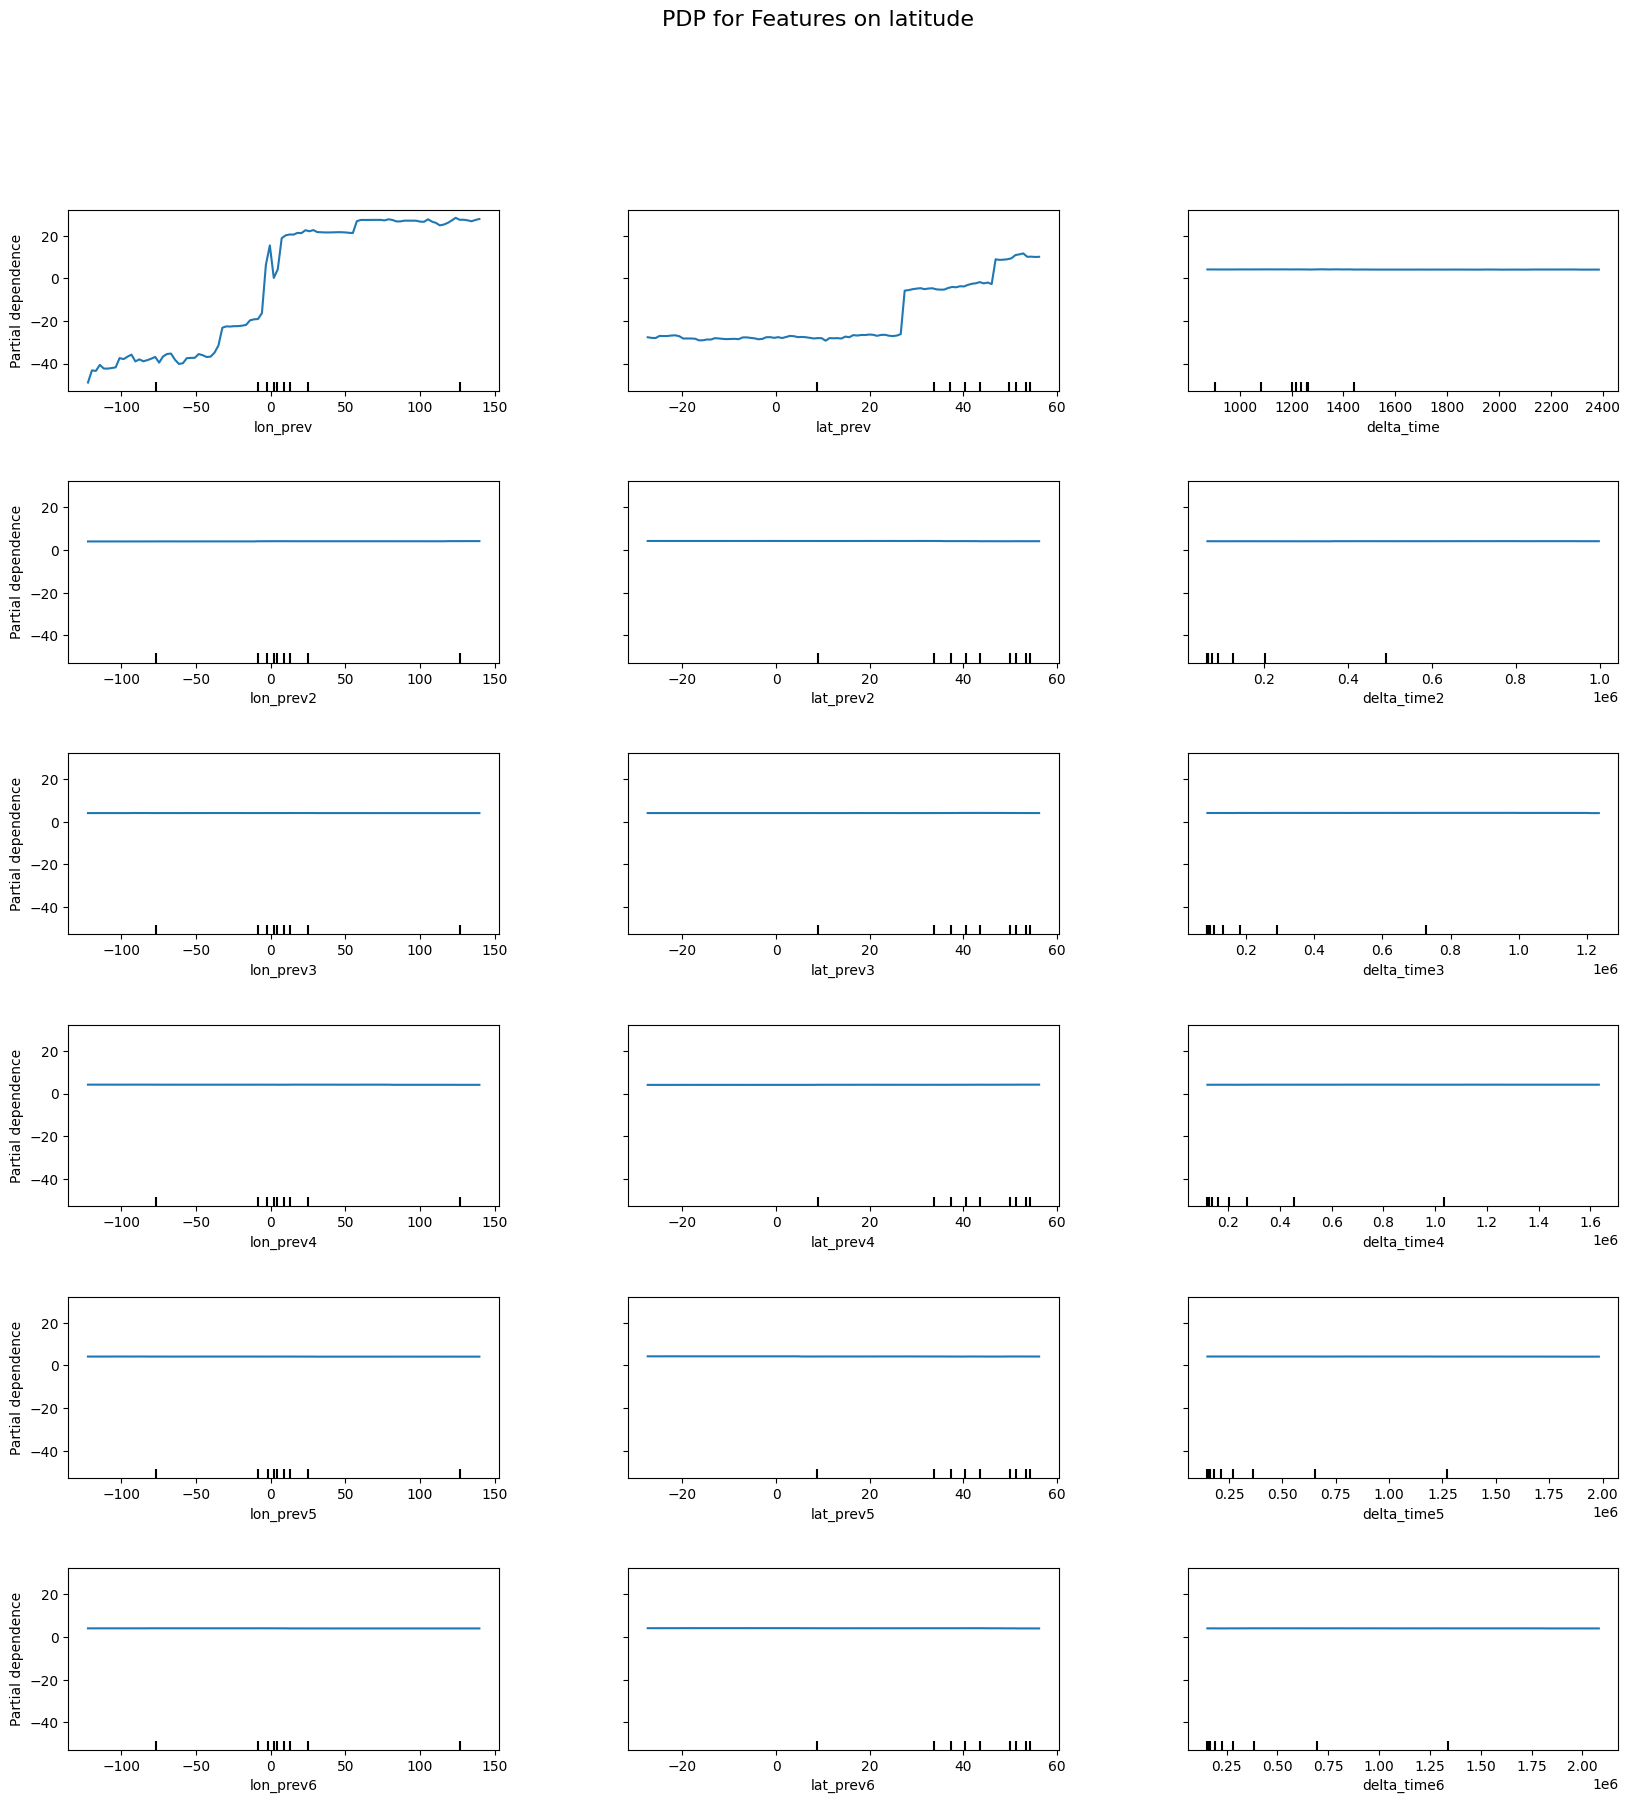

In [14]:
fig, ax = plt.subplots(figsize=(20, 20))
PartialDependenceDisplay.from_estimator(
    model, Xtrain, 
    features=['lon_prev', 'lat_prev', 'delta_time', 'lon_prev2', 'lat_prev2', 'delta_time2', 
              'lon_prev3', 'lat_prev3', 'delta_time3', 'lon_prev4', 'lat_prev4', 'delta_time4', 
              'lon_prev5', 'lat_prev5', 'delta_time5', 'lon_prev6', 'lat_prev6', 'delta_time6'], 
    target=0, 
    ax=ax
)


plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle("PDP for Features on latitude", fontsize=16) 
plt.show()


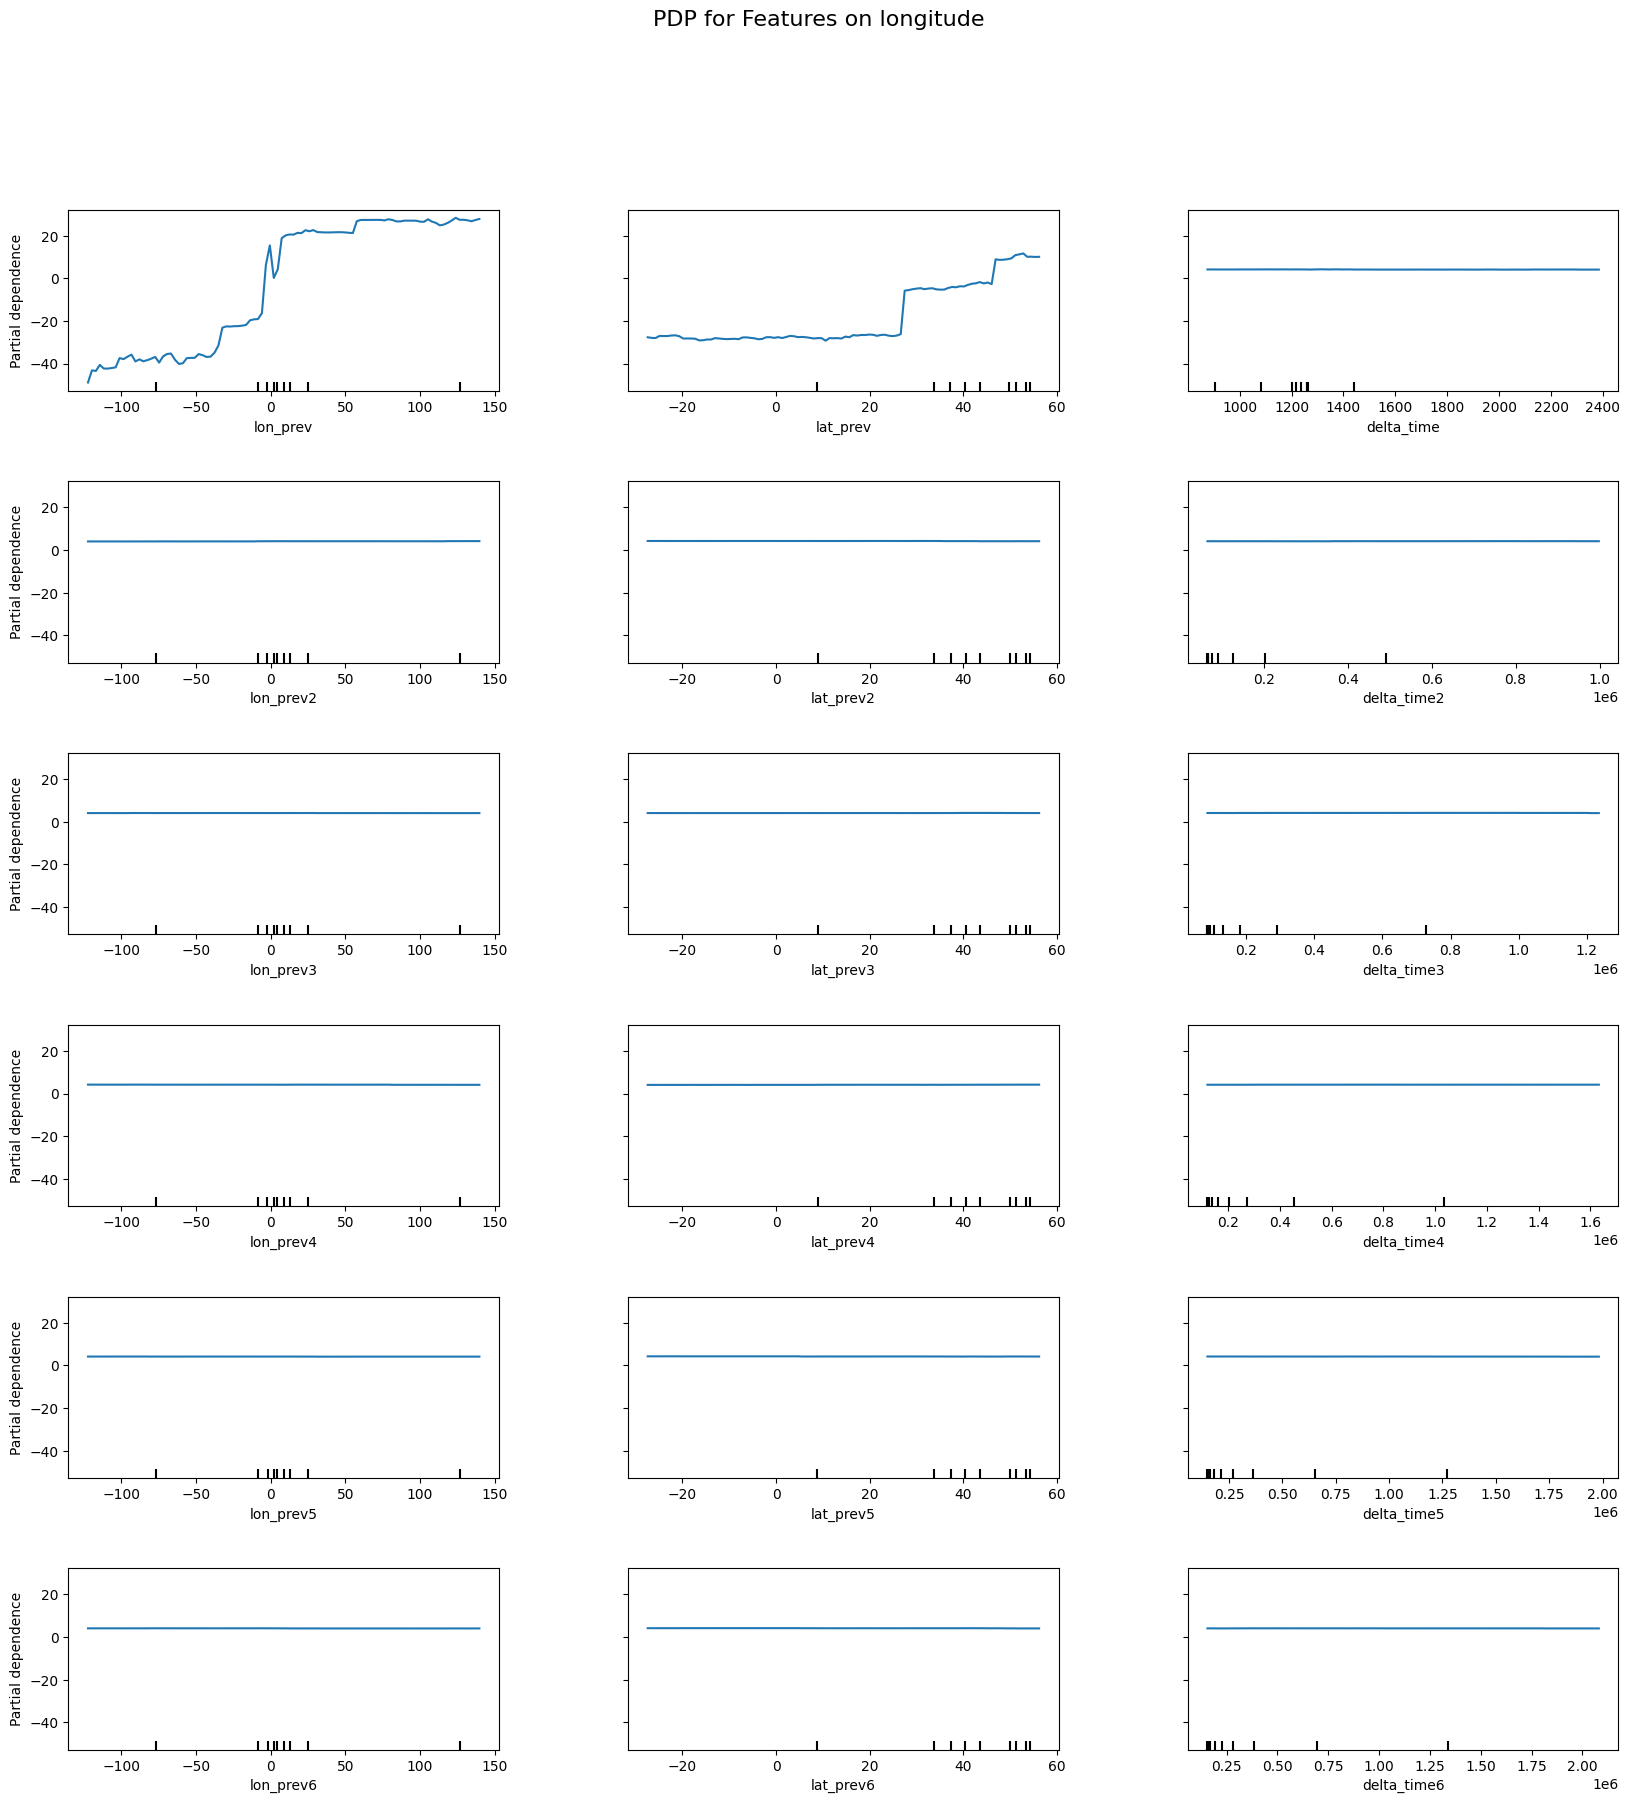

In [15]:


# Adjust figure size and spacing
fig, ax = plt.subplots(figsize=(20, 20))
PartialDependenceDisplay.from_estimator(
    model, Xtrain, 
    features=['lon_prev', 'lat_prev', 'delta_time', 'lon_prev2', 'lat_prev2', 'delta_time2', 
              'lon_prev3', 'lat_prev3', 'delta_time3', 'lon_prev4', 'lat_prev4', 'delta_time4', 
              'lon_prev5', 'lat_prev5', 'delta_time5', 'lon_prev6', 'lat_prev6', 'delta_time6'], 
    target=1, 
    ax=ax
)

# Adjust subplot layout to prevent overlap
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle("PDP for Features on longitude", fontsize=16)
plt.show()


Additionally, it's interesting to notice that while additional features coming from different timestamps are ranked as low importance and from the PDP plots it's clear they have low influence on the result, it did indeed improve model performance. The working theory of why that is the case is twofold: first of all, by accessing data from before the 5 day prediction horizion, every single instance of regression is based in at least a meager amount of true data and not from only previously predicted data. The second part might be due to the fact that by feeding 